In [1]:
import controlpy
import tqdm
import scipy

import numpy as np
import matplotlib.pyplot as plt

from uncertainty_utils import *
from controllers import *

### Problem setup
Assume the following state space model:
$$ x_{k+1} = Ax_k + Bu_k + w_k $$
With known noise covariance, and known initial state. We have an initial guess of the system dynamics: 
$$ A_{init} = A + \Delta^A, \\ B_{init} = B + \Delta^B  $$
With the estimated dynamics, we synthesize an infinite horizon LQR controller, which we use for control for a fixed amount of time. When the finite length horizon terminates, we create new estimates of the dynamics from the state-input trajectory as follows:
$$ A^*, B^*\min_{A,B} \sum_{i=0}^{N-1} ||A\hat{x}_i + Bu_i - \hat{x}_{i+1}||_2^2 + \lambda||[A, B]||_F^2$$
 We synthesize a new LQR controller, and perform another episode of control with the new system id, and analyze the convergence of the estimates and trajectories. 

In [29]:
# Dynamics
A_true = np.array([[1,.1],[0,1]])
B_true = np.array([0,1]).reshape((2,1))
N = A_true.shape[0]
M = B_true.shape[1]
x_init = np.array([2.7, 2])
input_limits = 2 * np.array([-1,1])

# LQR Cost:
Q = np.eye(N)
R = np.eye(M)

# Estimation and Simulation
process_noise_var = 1e-2
process_noise = process_noise_var * np.eye(N)
# process_noise[1,1] = 1e-2

# Experiment details
num_iterations = 100
regularization = 0
episode_length = 15
confidence = 0.95
sigma_init_id_error = 0.1
create_animation = False
animation_file = "traj_confidence.html"

### Show an initial run with the true dynamics

In [30]:
A_init = A_true
B_init = B_true
K, _, _= controlpy.synthesis.controller_lqr_discrete_time(A_init, B_init, Q, R)

In [31]:
x_init_sim = x_init + np.random.multivariate_normal(np.zeros(N), process_noise)

In [32]:
true_costs = []
for _ in range(num_iterations):
    x_traj, u_traj, true_opt_cost = sim_traj(A_true, B_true, K, Q, R, process_noise, x_init_sim,
                                             N=episode_length, input_limits=input_limits)
    true_costs.append(true_opt_cost)
expected_opt_cost = np.mean(true_costs)
expected_opt_cost_sigma = np.std(true_costs)

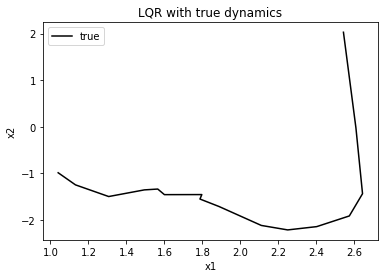

In [33]:
plt.plot(x_traj[:,0], x_traj[:,1],'k')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("LQR with true dynamics")
plt.legend(("true", "estimated"))

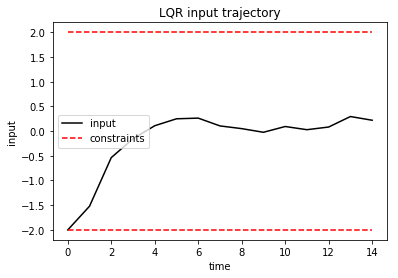

In [34]:
plt.plot(u_traj, "k")
plt.plot(np.ones(len(u_traj)) * input_limits[0], "r--")
plt.plot(np.ones(len(u_traj)) * input_limits[1], "r--")
plt.xlabel("time")
plt.ylabel("input")
plt.title("LQR input trajectory")
plt.legend(("input", "constraints"))

## Set up iterative System ID

In [47]:
A_est = A_true + sigma_init_id_error * np.random.randn(N,N)
B_est = B_true + sigma_init_id_error * np.random.randn(N,M)

#A_est[0,1] += sigma_init_id_error

TRAJ = "state traj"
COST = "cost"
INPUT_TRAJ = "input trajectory"
ERROR = "regression error"
COV = "covariance"
A_EST = "A_est"
B_EST = "B_est"
GAIN = "K"


data = {}
data[TRAJ] = []
data[COST] = []
data[INPUT_TRAJ] = []
data[ERROR] = [0]
data[COV] = [sigma_init_id_error * np.eye(N + M)]
data[A_EST] = [A_est]
data[B_EST] = [B_est]
data[GAIN] = []
data["process noise variance"] = process_noise_var

### Run initial iteration with random dynamics

In [48]:
x_init_true = x_init + np.random.multivariate_normal(np.zeros(N), process_noise)

K, _, _= controlpy.synthesis.controller_lqr_discrete_time(A_init, B_init, Q, R)
x_traj, u_traj, cost = sim_traj(A_true, B_true, K, Q, R, process_noise, x_init_true,
                                            N=episode_length, input_limits=input_limits)

data[TRAJ].append(x_traj)
data[INPUT_TRAJ].append(u_traj)
data[COST].append(cost)
data[GAIN].append(K)

### Run iterative LQG + system ID

In [49]:
for _ in tqdm.tqdm(range(num_iterations)):
    A_est_new, B_est_new, cov, error = multi_traj_regression(data[TRAJ], data[INPUT_TRAJ], regularization)
    A_est = A_est_new
    B_est = B_est_new
    
    x_init_sim = x_init + np.random.multivariate_normal(np.zeros(N), process_noise)
    K, _, _= controlpy.synthesis.controller_lqr_discrete_time(A_est, B_est,100 * cov[:2,:2] + Q, R)
    x_traj, u_traj, cost = sim_traj(A_true, B_true, K, Q, R, process_noise, x_init_sim,
                                                N=episode_length, input_limits=input_limits)

    data[TRAJ].append(x_traj)
    data[INPUT_TRAJ].append(u_traj)
    data[COST].append(cost)
    data[COV].append(cov)
    data[ERROR].append(error)
    data[A_EST].append(A_est)
    data[B_EST].append(B_est)
    data[GAIN].append(K)
    

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 222.28it/s]


## Plot results

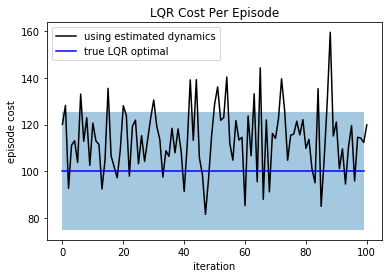

In [50]:
plt.plot(data[COST], 'k')
ec = expected_opt_cost * np.ones(num_iterations)
hi = 2 * expected_opt_cost_sigma + ec
lo = - 2 * expected_opt_cost_sigma + ec
plt.plot(expected_opt_cost * np.ones(num_iterations), "b")
plt.fill_between(np.arange(num_iterations), lo, hi, alpha=0.4)
plt.xlabel("iteration")
plt.ylabel("episode cost")
plt.title("LQR Cost Per Episode")
plt.legend(("using estimated dynamics", "true LQR optimal"))

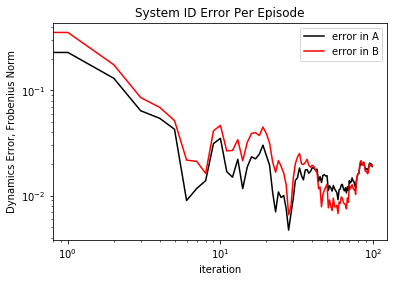

In [51]:
A_error = [np.linalg.norm(data[A_EST][i] - A_true) for i in range(num_iterations)]
B_error = [np.linalg.norm(data[B_EST][i] - B_true) for i in range(num_iterations)]
plt.loglog(A_error, "k")
plt.loglog(B_error, "r")
plt.xlabel("iteration")
plt.ylabel("Dynamics Error, Frobenius Norm")
plt.title("System ID Error Per Episode")
plt.legend(("error in A", "error in B"))

Text(0.5,1,'RMSE of Sys ID Per Episode')

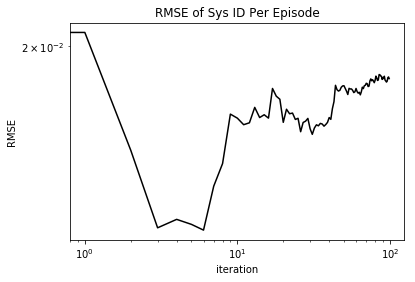

In [52]:
est_errors = [np.mean(np.linalg.norm(err, axis=1) ** 2) for err in data[ERROR][1:]]
plt.loglog(est_errors,"k")
plt.xlabel("iteration")
plt.ylabel("RMSE")
plt.title("RMSE of Sys ID Per Episode")

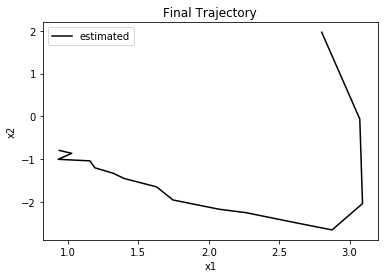

In [53]:
traj = data[TRAJ][-1]
plt.plot(traj[:,0], traj[:,1], "k")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Final Trajectory")
plt.legend(("estimated", "true"))

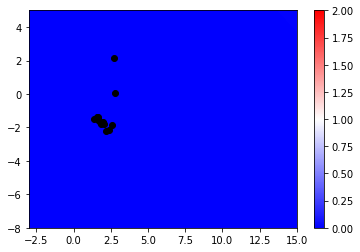

In [54]:
traj_id = 99
X, Y, uncertainties = plot_covariance(data[GAIN][traj_id], data[COV][traj_id], process_noise_var, (-3,15), (-8,5))
fig = plt.figure()
ax = plt.gca()
c = ax.contourf(X, Y, uncertainties, cmap="bwr",vmin=0,vmax=1)
m = plt.cm.ScalarMappable(cmap="bwr")
m.set_array(uncertainties)
m.set_clim(0., 2.)
plt.colorbar(m)
ax.plot(data[TRAJ][traj_id-1][:,0], data[TRAJ][traj_id-1][:,1],"ok")

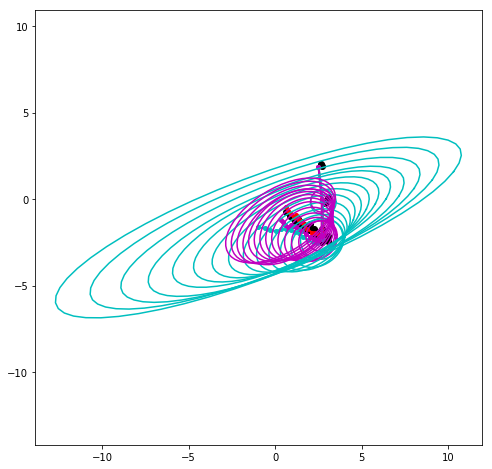

In [55]:
episode = 2
fig = plt.figure(figsize=(8,8))
plt.axis("equal")
x_traj = data[TRAJ][episode]
u_traj = data[INPUT_TRAJ][episode]
A_est = data[A_EST][episode]
B_est = data[B_EST][episode]

est_predicted_traj = sim_pred_traj(A_est, B_est, x_traj[0,:], u_traj)
true_predicted_traj = sim_pred_traj(A_true, B_true, x_traj[0,:], u_traj)

t_cheby = calc_t_chebyshev(confidence, A_true.shape[0])
model_cov = data[COV][episode]

est_covs = calc_covariances_input_traj(est_predicted_traj, u_traj, process_noise, model_cov, A_est)
true_covs = calc_covariances_input_traj(true_predicted_traj, u_traj, process_noise, np.zeros(model_cov.shape), A_true)

est_elipses = get_elipses(t_cheby, est_covs, est_predicted_traj)
true_elipses = get_elipses(t_cheby, true_covs, true_predicted_traj)

lw = 2
state_data = np.vstack(data[TRAJ][:episode])
plt.plot(state_data[:,0], state_data[:,1], "ko", label="data")
plt.plot(x_traj[:,0], x_traj[:,1],"r-o", label="trajectory", linewidth=lw, markersize=lw * 2)
plt.plot(est_predicted_traj[:,0], est_predicted_traj[:,1], "c-o", label="pred traj", linewidth=lw, markersize=lw * 2)
plt.plot(true_predicted_traj[:,0], true_predicted_traj[:,1], "m-o", linewidth=lw, markersize=lw * 2)
for est_elipse, true_elipse in zip(est_elipses, true_elipses):
    plt.plot(est_elipse[:,0], est_elipse[:,1], "c")
    plt.plot(true_elipse[:,0], true_elipse[:,1], "m")


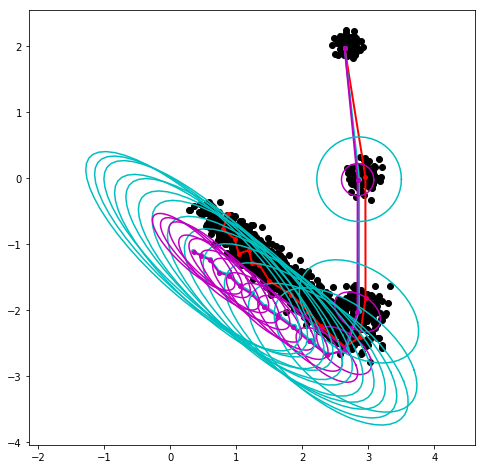

In [58]:
episode = 99
fig = plt.figure(figsize=(8,8))
plt.axis("equal")
x_traj = data[TRAJ][episode]
u_traj = data[INPUT_TRAJ][episode]
A_est = data[A_EST][episode]
B_est = data[B_EST][episode]
K = data[GAIN][episode]

est_predicted_traj = sim_pred_traj(A_est, B_est, x_traj[0,:], u_traj)
true_predicted_traj = sim_pred_traj(A_true, B_true, x_traj[0,:], u_traj)

t_cheby = calc_t_chebyshev(confidence, A_true.shape[0])
t_normal = calc_t(confidence, A_true.shape[0])
model_cov = data[COV][episode]

est_covs = calc_covariances_state_feedback(A_est, B_est, K, process_noise, model_cov, x_traj[0,:], episode_length)
true_covs = calc_covariances_state_feedback(A_true, B_true, K, process_noise, np.zeros(model_cov.shape), x_traj[0,:], episode_length)

est_elipses = get_elipses(t_cheby, est_covs, est_predicted_traj)
true_elipses = get_elipses(t_normal, true_covs, true_predicted_traj)

lw = 2
state_data = np.vstack(data[TRAJ][:episode])
plt.plot(state_data[:,0], state_data[:,1], "ko", label="data")
plt.plot(x_traj[:,0], x_traj[:,1],"r-o", label="trajectory", linewidth=lw, markersize=lw * 2)
plt.plot(est_predicted_traj[:,0], est_predicted_traj[:,1], "c-o", label="pred traj", linewidth=lw, markersize=lw * 2)
plt.plot(true_predicted_traj[:,0], true_predicted_traj[:,1], "m-o", linewidth=lw, markersize=lw * 2)
for est_elipse, true_elipse in zip(est_elipses, true_elipses):
    plt.plot(est_elipse[:,0], est_elipse[:,1], "c")
    plt.plot(true_elipse[:,0], true_elipse[:,1], "m")


In [27]:
# model_cov = np.zeros(model_cov.shape)
est_covs = calc_covariances_state_feedback(A_est, B_est, K, process_noise, model_cov, x_traj[0,:], episode_length)
comp_covs = calc_covariances_state_feedback_explicit(A_est, B_est, K, process_noise, model_cov, x_traj[0,:], episode_length)

In [28]:
[np.linalg.norm(comp_cov - est_cov) / np.linalg.norm(est_cov) for comp_cov, est_cov in zip(comp_covs, est_covs[2:])]

[1.1759257941988888e-16,
 1.5639739683729244e-16,
 1.8195104247845482e-09,
 3.1734082659380974e-09,
 4.8723944949994464e-09,
 6.647749673509319e-09,
 8.413838186765378e-09,
 1.0129814306769796e-08,
 1.1765933196756092e-08,
 1.3301821417478058e-08,
 1.4725306740531322e-08,
 1.6030483738360397e-08,
 1.7216053032490087e-08]

In [20]:
comp_covs[10]

array([[ 0.00612, -0.00492],
       [-0.00492,  0.006  ]])

In [21]:
if create_animation:
    animate_confidence_bounds(data, animation_file, A_true, B_true, confidence, process_noise)